# 15장 - 심층 합성곱 신경망으로 이미지 분륜 (part 1)

In [2]:
from IPython.display import Image

# 합성곱 신경망의 구성 요소

합성곱 신경망 또는 CNN은 뇌의 시각 피질이 물체를 인식할 때 동작하는 방식에서 영감을 얻은 모델이다.  

이미지 분류 작업에서 CNN이 탁월한 성능을 내기 때문에 이 특별한 종류의 피드포워드 신경망은 크게 주목받았고 컴퓨터 비전을 위한 머신 러닝 분야를 크게 발전시켰다.  

## CNN과 특성 계층 학습

(관련이 높은)핵심 특징을 올바르게 추출하는 것은 모든 머신 러닝 알고리즘의 성능에서 아주 중요한 요소이다. 전통적인 머신 러닝 모델은 도메인 전문가가 만든 특성에 의존하거나 컴퓨터를 사용한 특성 추출 기법에 바탕을 두고 있다.  

CNN과 같은 종류의 신경망은 원본 데이터에서 작업에 가장 유용한 특성을 자동으로 학습할 수 있다. 이런 이유 때문에 CNN 층을 특성 추출기로 생각하기도 한다. (입력층 바로 다음에 있는)층은 원본 데이터에서 저수준 특성을 추출한다. (종종 다층 퍼셉트론과 같은 완전 연결 층으로 만드는) 뒤쪽의 층은 이런 특성을 사용하여 연속적인 타깃 값이나 클래스 레이블을 예측한다. 

특정 종류의 다층 신경망과 특히 심층 합성곱 신경망은 각 층별로 저수준 특성을 연결하여 고수준 특성을 만듦으로써 소위 특성 계층을 구성한다. 예를 들어 이미지를 다룬다면 모서리나 동그라미 같은 저수준 특성이 앞쪽 층에서 추출된다. 이 특성들이 연결되어 고수준 특성을 형성한다. 이런 고수준 특성은 건물, 자동차, 강아지 같은 더 복잡한 모양을 형성할 수 있다.

In [3]:
Image(url='https://git.io/JL5O3', width=700)

위의 그림에서 보듯이 CNN은 입력 이미지에서 **특성 맵**(feature map)을 만든다. 이 맵의 각 원소는 입력 이미지의 국부적인 픽셀 패치(patch)에서 유도된다.  
이런 국부적인 픽셀 패치를 국부 수용장(local receptive field)이라고 말한다. CNN은 일반적으로 이미지 관련 작업을 매우 잘 수행한다. 대체적으로 다음 두 개의 중요한 아이디어 때문이다.  

- 희소 연결: 특성 맵에 있는 하나의 원소는 작은 픽셀 패치 하나에만 연결된다.  
- 파라미터 공유: 동일한 가중치가 입력 이미지의 모든 패치에 사용된다.  

이 두 아이디어 결과로 일반적인 완전 연결 MLP를 합성곱 층으로 바꾸면 네트워크의 가중치(파라미터)개수가 극적으로 감소하고 중요 특징을 잡아내는 능력이 향상된다. 이미지 데이터를 보면 가까이 있는 픽셀들이 멀리 떨어져 있는 픽셀보다 연관성이 높다고 가정할 수 있다.  

일반적으로 CNN은 여러 개의 **합성곱**(conv) 층과 **풀링**(Pooling, P)이라고도 하는 서브샘플링(subsampling) 층으로 이루어져 있다.  
마지막에는 하나 이상의 완전 연결(FC) 층이 따라온다. 완전 연결 층은 모든 유닛 i가 모든 출력 유닛 j에 가중치 $w_{ij}$로 연결되어 있는 다층 퍼셉트론이다.  

**풀링 층**(pooling layer)으로 알려진 서브샘플링 층은 학습되는 파라미터가 없다. 즉, 풀링 층에는 가중치나 절편 유닛이 없다. 합성곱이나 완전 연결 층은 훈련 도중 최적화되는 가중치와 절편을 가진다.  

## 이산 합성곱 수행

**이산 합성곱**(discrete convolution(또는 간단히 합성곱)이 CNN의 기본 연산이다. 이 연산의 작동원리를 아는 것이 아주 중요하다. 

#### 1차원 이산 합성곱 연산 수행  
앞으로 사용할 기본적인 정의와 기호를 설명하는 것부터 시작해보자.  
두 개의 벡터 $x$와 $w$에 대한 이산 합성곱은 $y=x*w$처럼 나타낸다. $x$는 입력(이따금 신호라고 부름)이고 $w$는 **필터**(filter) 또는 **커널**(kernel)이라고 부른다.  
이산 합성곱의 수학적 정의는 다음과 같다.  
$$y=x*w \rightarrow y[i]=\sum^{+\infty}_{k=-\infty}x[i-k]w[k]$$  

첫째 인덱스 $-\infty$부터 $+\infty$까지 합은 특히 이상하게 보인다. 머신 러닝 애플리케이션은 항상 유한한 특성 벡터를 다루기 때문이다.  
이전 공식에 있는 덧셈을 올바르게 계산하려면 $x$와 $w$가 0으로 채워져 있다고 가정해야 한다. 또한, 출력 벡터 $y$도 0으로 채워진 무한 크기가 된다. 이는 실제 상황에서는 유용하지 않기 때문에 유한한 개수의 0으로 $x$가 패딩된다.  

이 과정을 **제로 패딩**(zero padding) 또는 **패딩**(padding)이라고 한다. 

In [4]:
Image(url='https://git.io/JL5On', width=700)

원본 입력 $x$와 필터 $w$가 각각 n개, m개의 원소를 가지고 $m \le n$이라고 가정해 본다. 패딩도니 벡터 $x^{P}$크기는 $n+2P$이다. 이산 합성곱을 계산하기 위한 실제 공식은 다음과 같이 바뀐다.  
$$y=x*w \rightarrow y[i]=\sum^{k=m-1}_{k=0}x[i+m-k]w[k]$$  

In [5]:
Image(url='https://git.io/JL5O8', width=700)

위의 그림은 $x=(3,2,1,7,1,2,5,4)$이고 $w=({1 \over 2}, {3 \over 4}, 1, {1 \over 4})$일 때 처음 세 개의 출력 원소를 계산하는 경우를 보여준다.  

이 예에서 패딩 크기는 0이다. 회전된 필터 $w^{r}$은 2칸씩 이동한다. 이동하는 양은 스트라이드(stride)라고 하며, 또 하나의 합성곱 하이퍼파라미터이다. 여기서 스트라이드 2이다.  
스트라이드는 입력 벡터의 크기보다 작은 양수 값이어야 한다.  
</br>
</br>
#### 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기
지금까지 유한한 크기의 출력 벡터를 얻기 위해 합성곱에 제로 패딩을 사용했다. 기술적으로 $p \ge 0$인 어떤 패딩도 적용할 수 있다. $p$값에 따라 $x$에서 경계에 있는 셀은 중간 셀과 다르게 처리된다.  

$n=5, m=3, p=0$인 경우를 생각해보자. $x[0]$는 하나의 출력 원소를 계산하는 데만 사용된다. $x$원소를 이렇게 다르게 취급하기 때문에 가운데 있는 $x[2]$가 대부분의 계산에 사용되어 강조되는 효과를 낸다.  
여기서는 $p=2$를 사용하면 이 문제를 피할 수 있다. $x$의 각 원소가 세 개의 $y$ 원소 계산에 참여한다.  

또 출력 $y$ 크기는 사용한 패딩 방법에 따라 달라진다.  

실전에서 자주 사용하는 세 개의 패딩 방법은 풀(full) 패딩, 세임(same) 패딩, 밸리드(valid) 패딩이다.  

- 풀 패딩은 패딩 파라미터 $p$를 $p=m-1$로 설정한다. 풀 패딩은 출력 크기를 증가시키기 때문에 합성곱 신경망 구조에서는 거의 사용되지 않는다.  
- 세임 패딩은 출력 크기가 입력 벡터 $x$와 같아야 할 때 사용한다. 이때 패딩 파라마미터 $p$는 입력과 출력 크기가 동일해야 하기 때문에 필터 크기에 따라 결정된다.  
- 마지막으로 밸리드 패딩 합성곱은 $p=0$인 경우를 말한다.(패딩 없음)  

In [6]:
Image(url='https://git.io/JL5Ow', width=700)

위의 그림은 세 개의 패딩 모드를 보여준다. 입력은 5X5 픽셀, 커널은 3X3 크기, 스트라이드는 1인 경우이다.   

***합성곱 신경망에서 가장 많이 사용되는 패딩 방법은 세임 패딩***이다. 다른 패딩 방식에 비해 장점은 세임 패딩이 벡터의 크기를 유지시킨다는 것이다. 컴퓨터 비전 분야의 이미지 관련된 작업이라면 입력 이미지의 높이와 너비가 유지된다. 이 때문에 네트워크 구조를 설계하기 쉽다.  

풀 패딩이나 세임 패딩에 비해 밸리드 패딩의 단점은 신경망에 층이 추가될수록 점진적으로 텐서 크기가 줄어드는 것이다. 이는 신경망 성능을 나쁘게 만들 수 있다.  

실전에서 세임 패딩으로 너비와 높이를 유지시키고 풀링에서 크기를 감소시킨다. 풀 패딩은 입력보다 출력 크기를 증가시키므로 경계 부분의 영향을 최소화하는 것이 중요한 신호 처리 애플리케이션에서 보통 사용한다. 딥려닝에서는 경계 부분의 영향이 크기 않기 때문에 실전에서는 풀 패딩이 거의 사용되지 않는다.  
</br>
</br>
#### 합성곱 출력 크기 계산 
합성곱 출력 크기는 입력 벡터 위를 필터 $w$가 이동하는 전체 횟수로 결정된다. 입력 벡터의 크기는 $n$이고 필터 크기는 $m$이라고 가정해 보자. 패딩이 $p$이고 스트라이드가 $s$인 $x*w$ 출력 크기는 다음과 같이 계산된다.  
$$o=\left[ {n+2p-m \over s} \right]+1$$  

다음 두 경우를 생각해보자.  
- 입력 벡터 크기가 10이고 합성곱 커널 크기가 5, 패딩이 2, 스트라이드가 1일 때 출력 크기를 계산해보자.  
$$n=10, m=5, p=2, s=1 \rightarrow o=\left[ {10+2\times2-5 \over 1}\right]+1 = 10$$  
(이때는 출력 크기가 입력과 동일하므로 세임 패딩이다.)  

- 커널 크기가 3이고 스트라이드가 2이면 같은 입력 벡터일 때 출력 크기가 어떻게 바뀔까?  
$$n=10, m=3, p=2, s=2 \rightarrow o=\left[  {10+2\times2-3 \over 2}\right]+1=6$$  



In [7]:
import tensorflow as tf
import numpy as np

print('텐서플로 버전:', tf.__version__)
print('넘파이 버전: ', np.__version__)

텐서플로 버전: 2.5.0
넘파이 버전:  1.19.5


In [8]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot)) / s) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d 구현:',
      conv1d(x, w, p=2, s=1))

print('넘파이 결과:',
      np.convolve(x, w, mode='same')) 

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과: [ 5 14 16 26 24 34 19 22]


####  2D 이산 합성곱 수행
$m_{1} \le n_{1}$이고 $m_{2} \le n_{2}$인 행렬 $X_{n_{1}\times n_{2}}$와 필터 행렬 $W_{m_{1} \times m_{2}}$같은 2차원 입력을 다룰 때 $X$와 $W$의 2D 합성곱 결과는 행렬 $Y=X*W$가 된다.  
$$Y= X*W \rightarrow Y[i,j] = \sum^{+\infty}_{k_{1}=-\infty} \sum^{+\infty}_{k_{2}=-\infty} X[i-k_{1}, j-k_{2}]W[k_{1},k_{2}]$$  

차원 하나를 제거하면 남은 공식이 이전의 1D 합성곱과 정확히 동일하다. 사실 제로 패딩, 필터 행렬의 회전, 스트라이드 같은 이전에 언급한 모든 기법도 2D 합성곱에 적용할 수 있다.

In [9]:
Image(url='https://git.io/JL5OP', width=700)

위의 그림은 8X8인 입력 행렬과 3X3 크기의 커널을 사용한 2D 합성곱은 보여준다. 입력 행렬이 p=1로 제로 패딩되어 있다. 이로 인해 2D 합성곱은 8X8 크기의 출력을 만든다.

In [10]:
Image(url='https://git.io/JL5OD', width=600)

In [11]:
Image(url='https://git.io/JL5OS', width=800)

위의 예는 패딩 p=(1,1)과 스트라이드 s=(2,2)일 때 입력 행렬 $X_{3\times 3}$과 커널 행렬 $W_{3 \times 3}$ 사이의 2D 합성곱 계산을 보여준다.

In [12]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d 구현:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('싸이파이 결과:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
싸이파이 결과:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## 서브샘플링

서브샘플링은 전형적인 두 종류의 풀링 연산으로 합성곱 신경망에 적용된다. **최대 풀링**(max-pooling)과 **평균 풀링**(mean-pooling 또는 average-pooling)이다.  
풀링 층은 보통 $P_{n_{1} \times n_{2}}$로 표시한다. 

In [13]:
Image(url='https://git.io/JL5OH', width=700)

풀링의 장점은 두 가지이다.  
- 풀링(최대 풀링)은 지역 불변성을 만든다. 국부적인 작은 변화가 최대 풀링의 결괄르 바꾸지 못한다는 의미이다. 결국 입력 데이터에 있는 잡음에 좀 더 안정적인 특성을 생성한다.  
- 풀링은 특성 크기를 줄이므로 계산 효율성을 높인다. 또 특성 개수가 줄어들면 과대적합도 감소된다.  

풀링이 아직 CNN 구조의 핵심 요소이지만 몇몇 CNN 구조는 풀링 층을 사용하지 않고 개발되었다. 특성 맵의 크기를 줄이기 위해 풀링 층을 사용하는 대신 스트라이드 2인 합성곱 층을 사용한다.  

스트라이드 2인 합성곱 층을 합습되는 가중치가 있는 풀링 층으로 생각할 수 있다. 

# 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

일반적인 신경망에서 가장 중요한 연산은 행렬-벡터 곱셈이다.  
예를 들어 행렬-벡터 곱셈을 사용하여 활성화 함수의 입력 $z=Wx+b$를 계산한다. 여기서 $x$는 픽셀을 나타내는 열 벡터이고 $W$는 입력 필셀과 각 은닉 유닛을 연결하는 가중치 행렬이다. 

## 여러 개의 입력 또는 컬러 채널 다루기

합성곱 층의 입력 샘플에는 $N_{1} \times N_{2}$ 차원인 하나 이상의 2D 배열 또는 행렬이 포함될 수 있다. 이런 $N_{1} \times N_{2}$ 행렬을 **채널**(channel)이라고 한다.  
합성곱 층은 랭크 3 텐서를 입력으로 기대한다. 예를 들어 3차원 배열 $X_{N_{1} \times N_{2} \times C_{m}}$을 사용해야 한다. 여기서 $C_{m}$이 입력 채널 크기이다.  
예를 들어 CNN의 첫 번째 층에 입력되는 이미지를 생각해보자. RGB 모드의 컬러 이미지라면 $C_{m}=3$이다. 이미지가 그레이스케일(grayscale)이라면 흑백의 픽셀 강도를 가진 하나의 채널만 있으므로 $C_{m}=1$이다.

### Note 
이미지 파일 읽기

In [14]:
!wget https://git.io/JL5Ob -O example-image.png

--2022-11-24 11:22:37--  https://git.io/JL5Ob
git.io (git.io) 해석 중... 140.82.114.22
다음으로 연결 중: git.io (git.io)|140.82.114.22|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 302 Found
위치: https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image.png [따라감]
--2022-11-24 11:22:38--  https://github.com/rickiepark/python-machine-learning-book-3rd-edition/raw/master/ch15/example-image.png
github.com (github.com) 해석 중... 20.200.245.247
다음으로 연결 중: github.com (github.com)|20.200.245.247|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 302 Found
위치: https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image.png [따라감]
--2022-11-24 11:22:38--  https://raw.githubusercontent.com/rickiepark/python-machine-learning-book-3rd-edition/master/ch15/example-image.png
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
다음으로 연결 중: raw.githubusercontent.com (r

In [16]:
import tensorflow as tf

img_raw = tf.io.read_file('example-image.png')
img = tf.image.decode_image(img_raw)
print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 개수: 3
이미지 데이터 타입: <dtype: 'uint8'>
tf.Tensor(
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]], shape=(2, 2, 3), dtype=uint8)


In [20]:
import imageio


img = imageio.imread('example-image.png')
print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[2])
print('이미지 데이터 타입:', img.dtype)
print(img[100:102, 100:102, :])

이미지 크기: (252, 221, 3)
채널 개수: 3
이미지 데이터 타입: uint8
[[[179 134 110]
  [182 136 112]]

 [[180 135 111]
  [182 137 113]]]


/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_6203/504236035.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('example-image.png')


In [21]:
Image(url='https://git.io/JL5O5', width=800)

위의 그림에 나온 합성곱 층과 풀링 층이 포함된 예제를 통해 신경망의 합성곱 계산을 정리한다.  
이 예에는 입력 채널이 세 개이다. 커널 텐서는 4차원이다. 각 커널 행렬은 $m_{1} \times m_{2}$ 크기이고 입력 채널에 한 개씩 세 개이다.  
이런 커널 텐서가 다섯 개의 출력 특성 맵을 만들기 위해 다섯 개가 있다. 마지막으로 특성 맵을 서브샘플링하기 위해 풀링 층이 있다.

## 드롭아웃으로 신경망 규제

일반적인 (완전 연결) 신경망 또는 CNN 중 어떤 것을 사용하든지 네트워크 크기를 결정하는 것은 항상 어려운 문제이다. 어느 정도 좋은 성능을 얻으려면 가중치 행렬 크기와 층 개수를 튜닝해야만 한다.  

14장에서 보았듯이 은닉층이 없는 간단한 신경망은 선형 결정 경계만 감지할 수 있어 XOR이나 비슷한 문제를 해결하는 데 충분하지 않다. 네트워크의 수용 능력은 얼마나 복잡한 함수를 근사할 수 있는지를 나타낸다. 파라미터 개수가 비교적 적은 네트워크는 용량이 작기 때문에 **과소적합**되기 쉽다. 이는 복잡한 데이터셋에 내재된 구조를 학습할 수 없기 때문에 성능이 나빠진다. 반면 아주 큰 네트워크는 **과대적합**될 가능성이 많다. 이런 네트워크가 훈련 데이터를 외워 버리면 훈련 데이터셋에서는 아주 잘 작동하지만 별도의 테스트 데이터셋에서는 나쁜 성능을 낼 것이다. 실제 머신 러닝 문제를 다룰 때는 네트워크가 커야 하는지 사전에 알 수 없다.  

이 문제를 해결하기 위한 한 가지 방법은 다음과 같다.  
먼저 훈련 데이터셋에서 잘 동작하도록 비교적 큰 용량의 네트워크를 구축한다. 그다음 과대적합을 막기 위해 한 개 이상의 규제 방법을 적용하여 별도의 테스트 데이터셋 같은 새로운 데이터에서 일반화 성능을 높인다.  

3장에서 L1 규제와 L2 규제를 소개했다. L1 규제와 L2 규제 방법이 손실 함수에 페널티를 추가하여 훈련 중에 가중치 크기를 작게 만들기 때문에 과대적합의 영향을 막거나 감소시킬 수 있다. L1 규제와 L2 규제 모두 신경망에 사용할 수 있지만 L2 규제가 둘 중 더 많이 사용된다. 이외에도 **드롭아웃**(dropout)같은 신경망을 규제하는 다른 방법이 있다. 드롭아웃에 대해 설명하기 전에 합성곱이나 완전 연결 신경망에서 L2 규제를 사용하는 방법을 알아보자. 

In [22]:
from tensorflow import keras


conv_layer = keras.layers.Conv2D(
    filters=16, kernel_size=(3, 3),
    kernel_regularizer=keras.regularizers.l2(0.001))

fc_layer = keras.layers.Dense(
    units=16, kernel_regularizer=keras.regularizers.l2(0.001))

최근에는 **드롭아웃**(dropout) 방법이 인기가 높다. 신경망에 적용하여 과대적합을 피할 수 있고 따라서 일반화 성능이 향상된다.  
드롭아웃은 보통 뒤쪽 층의 은닉 유닛에 적용하고 다음과 같이 동작한다.  
신경망을 훈련하는 동안 반복마다 은닉 유닛의 일부가 확률 $p_{drop}$만큼 랜덤하게 드롭아웃된다. 드롭아웃 확률은 사용자가 지정해야 한다. 니티시 스리바스타바 등의 논문에 따르면 많이 사용하는 값은 $p=0.5$이다.  
일부 뉴런의 일부를 드롭아웃할 때 없어진 뉴런을 보상하기 위해 남은 뉴런에 연결된 가중치 값을 크게 한다.  

랜덤한 드롭아웃의 영향으로 네트워크는 데이터에서 여분의 표현을 학습한다. 따라서 네트워크가 일부 은닉 유닛의 활성화 값에 의존할 수 없다. 훈련 과정에서 언제든지 은닉 유닛이 꺼질 수 있기 때문이다. 이는 네트워크가 데이터에서 더 일반적이고 안정적인 패턴을 학습하게 만든다.  

In [23]:
Image(url='https://git.io/JL5Oh', width=700)

여기서 보듯이 훈련 단계에서만 유닛이 랜덤하게 꺼진다는 것이 중요하다. 평가(추론) 단계에서는 모든 유닛이 활성화되어야 한다.  
훈련과 예측 단계의 전체 활성화 값의 스케일을 맞추기 위해 활성화된 뉴런 출력이 적절히 조정되어야 한다.  

실전에서 예측을 만들 때 활성화 값의 출력을 조정하는 것은 불편하기 때문에 텐서플로나 다른 라이브러리들은 훈련 단계의 활성화를 조정한다. 이런 방법을 역 드롭아웃(inverse dropout)이라고 부른다. 

관계가 명백하지는 않지만 드롭아웃을 앙상블 모델의 합의(평균)로 이해할 수 있다.  
앙상블 모델에서는 여러 개의 모델을 독립적으로 훈련한다. 예측할 때 훈련된 전체 모델의 결과를 평균하거나 다수를 사용한다. 앙상블 모델이 단일 모델보다 더 높은 성능을 낸다는 것을 보았다. 하지만 딥러닝에서 여러 개의 모델을 훈련하고 출력을 평균하는 것은 계산 비용이 많이 든다. 드롭아웃은 차선책으로 한 번에 많은 모델을 훈련하고 테스트 또는 예측할 때 평균값을 계산하는 효과적인 방법을 제공한다.  

## 분류를 위한 손실 함수

13장에서 렐루, 시그모이드, tanh 같은 여러 가지 활성화 함수를 보았다.  
렐루와 같은 몇몇 활성화 함수는 모델에 비선형성을 더하기 위해 신경망의 중간(은닉)층에 주로 사용된다. (이진 분류일 경우) 시그모이드와 (다중 분류일 경우) 소프트맥스 활성화 함수는 마지막 (출력)층에 추가되어 클래스 소속 확률을 출력한다.  
시그모이드와 소프트맥스 활성화 함수가 출력층에 포함되지 않으면 모델은 클래스 소속 확률 대신 로짓을 계산할 것이다.  

분류 문제에 초점을 맞추어 보면 문제의 종류(이진 분류 대 다중 분류)와 출력의 형태(로짓 대 확률)에 따라 모델 훈련에 필요한 적절한 손실 함수를 선택해야 한다.  
**이진 크로스 엔트로피**(binary cross-entropy)는 이진 분류를 위한 손실 함수이다. **범주형 크로스 엔트로피**(categorical cross-entropy)는 다중 분류를 위한 손실 함수이다. 

In [24]:
Image(url='https://git.io/JL53f', width=800)

In [26]:
from distutils.version import LooseVersion as Version


####### 이진 크로스 엔트로피
bce_probas = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

logits = tf.constant([0.8])
probas = tf.keras.activations.sigmoid(logits)

tf.print(
    'BCE (확률): {:.4f}'.format(
    bce_probas(y_true=[1], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    bce_logits(y_true=[1], y_pred=logits)))


####### 범주형 크로스 엔트로피
cce_probas = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False)
cce_logits = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True)

logits = tf.constant([[1.5, 0.8, 2.1]])
probas = tf.keras.activations.softmax(logits)

if Version(tf.__version__) >= '2.3.0':
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[[0, 0, 1]], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[[0, 0, 1]], y_pred=logits)))
else:
    tf.print(
        'CCE (확률): {:.4f}'.format(
        cce_probas(y_true=[0, 0, 1], y_pred=probas)),
        '(로짓): {:.4f}'.format(
        cce_logits(y_true=[0, 0, 1], y_pred=logits)))

####### 희소 범주형 크로스 엔트로피
sp_cce_probas = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False)
sp_cce_logits = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

tf.print(
    'Sparse CCE (확률): {:.4f}'.format(
    sp_cce_probas(y_true=[2], y_pred=probas)),
    '(로짓): {:.4f}'.format(
    sp_cce_logits(y_true=[2], y_pred=logits)))

BCE (확률): 0.3711 (로짓): 0.3711
CCE (확률): 0.5996 (로짓): 0.5996
Sparse CCE (확률): 0.5996 (로짓): 0.5996


/var/folders/tb/x7hcv5j94gn9b46c7qc1vfth0000gn/T/ipykernel_6203/1516748754.py:27: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if Version(tf.__version__) >= '2.3.0':


# 텐서플로를 사용하여 심층 합성곱 신경망 구현

여기서는 손글씨 숫자 분류를 위해 CNN을 구현하여 MLP(DNNClassifier)보다 더 높은 성능을 낼 수 있는지 확인해보자.

## 다층 CNN 구조

입력은 28X28 크기의 그레이스케일 이미지이다. 채널 개수(그레이스케일 이미지이므로 1)와 입력 이미지의 배치를 생각하면 입력 텐서의 차원은 batchsizeX28X28X1이 된다.  

입력 데이터는 5X5 크기의 커널을 가진 두 개의 합성곱 층을 지난다.  
첫 번째 합성곱은 32개의 특성 맵을 출력하고 두 번째는 64개의 특성 맵을 출력한다. 각 합성곱 층 다음에는 서브샘플링으로 최대 풀링 연산 $P_{2 \times 2}$가 뒤따른다. 그다음 완전 연결 층의 출력이 최종 소프트맥스 층인 두 번째 완전 연결 층으로 전달된다.   

각 층의 텐서 차원은 다음과 같다.  
- 입력: [batchsize X 28 X 28 X 1]
- 합성곱_1: [batchsize X 28 X 28 X 32]  
- 풀링_1: [batchsize X 14 X 14 X 32]  
- 합성곱_2: [batchsize X  14 X 14 X 64]  
- 풀링_2: [batchsize X 7 X 7 X 64]  
- 완전 연결_1: [batchsize X 1024]  
- 완전 연결과 소프트맥스 층: [batchsize X 10]  

## 데이터 적재와 전처리

In [27]:
import tensorflow_datasets as tfds

## 데이터 적재
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
datasets = mnist_bldr.as_dataset(shuffle_files=False)
mnist_train_orig = datasets['train']
mnist_test_orig = datasets['test']

/Users/hanhyeongu/miniforge3/envs/hg/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
NUM_EPOCHS = 20

In [29]:
mnist_train = mnist_train_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))
            
mnist_test = mnist_test_orig.map(
    lambda item: (tf.cast(item['image'], tf.float32)/255.0,
                  tf.cast(item['label'], tf.int32)))

tf.random.set_seed(1)

mnist_train = mnist_train.shuffle(buffer_size=BUFFER_SIZE,
                                  reshuffle_each_iteration=False)

mnist_valid = mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train = mnist_train.skip(10000).batch(BATCH_SIZE)

## 텐서플로 케라스 API를 사용하여 CNN 구현

#### 케라스에서 CNN 층 설정하기
- Conv2D: tf.keras.layers.Conv2D  
    - filters  
    - kernel_size  
    - strides  
    - padding  
- MaxPooling2D: tf.keras.layers.MaxPool2D  
    - pool_size  
    - strids  
    - padding  
- Dropout: tf.keras.layers.Dropout2D  
    - rate

#### 케라스로 CNN 구성하기

In [30]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    data_format='channels_last',
    name='conv_1', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_1'))
    
model.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=(5, 5),
    strides=(1, 1), padding='same',
    name='conv_2', activation='relu'))

model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool_2'))

In [31]:
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 7, 7, 64])

튜플로 지정한 입력 크리에 대해 `compute_output_shape` 메서드가 계산한 출려 크기는 (16, 7, 7, 64)이다.  
이는 64개의 채널이 있고 높이와 너비가 7X7인 특성 맵이다. 첫 번째 차원은 배치 차원으로 여기서는 임의로 16이라고 정했다. 

다음에 추가할 층은 밀집 (또는 완전 연결)층이다. 합성곱 층과 풀링 층 위에 분류기를 구현하기 위해서 필요하다.  
이 층의 입력은 랭크 2, 즉 [배치 크기 X 입력 유닛 개수]이어야 한다. 따라서 앞 층의 출력을 밀집 층에 맞게 펼쳐야 한다. 

In [32]:
model.add(tf.keras.layers.Flatten())
    
model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 3136])

그다음 두 개의 밀집 층을 놓고 그 사이에 드롭아웃 층을 추가한다. 

In [33]:
model.add(tf.keras.layers.Dense(
    units=1024, name='fc_1', 
    activation='relu'))

model.add(tf.keras.layers.Dropout(
    rate=0.5))
    
model.add(tf.keras.layers.Dense(
    units=10, name='fc_2',
    activation='softmax'))

이름이 `'fc_2'`인 마지막 완전 연결 층은 MNIST 데이터셋의 클래스 레이블 열 개에 대응하는 열 개의 출력 유닛을 가진다.  
또한, 입력 샘플의 클래스 소속 활률을 얻기 위해 소프트맥스 활성화 함수를 사용한다. 따라서 각 샘플의 확률의 합은 1이 된다. 

In [34]:
tf.random.set_seed(1)
model.build(input_shape=(None, 28, 28, 1))

model.compute_output_shape(input_shape=(16, 28, 28, 1))

TensorShape([16, 10])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        51264     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              3212288   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [36]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']) # same as `tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')`

history = model.fit(mnist_train, epochs=NUM_EPOCHS, 
                    validation_data=mnist_valid, 
                    shuffle=True)

Epoch 1/20


2022-11-24 12:16:56.126414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-24 12:16:56.129115: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-24 12:16:56.129640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9578

2022-11-24 12:17:08.754289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 14s 15ms/step - loss: 0.1356 - accuracy: 0.9578 - val_loss: 0.0577 - val_accuracy: 0.9828
Epoch 2/20
782/782 [==============================] - 11s 13ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.0438 - val_accuracy: 0.9881
Epoch 3/20
782/782 [==============================] - 12s 15ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.0514 - val_accuracy: 0.9866
Epoch 4/20
782/782 [==============================] - 12s 15ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0588 - val_accuracy: 0.9869
Epoch 5/20
782/782 [==============================] - 12s 15ms/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 0.0567 - val_accuracy: 0.9861
Epoch 6/20
782/782 [==============================] - 11s 14ms/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0687 - val_accuracy: 0.9871
Epoch 7/20
782/782 [==============================] - 11s 14ms/step - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0586 - val_accuracy: 0.9887
Epo

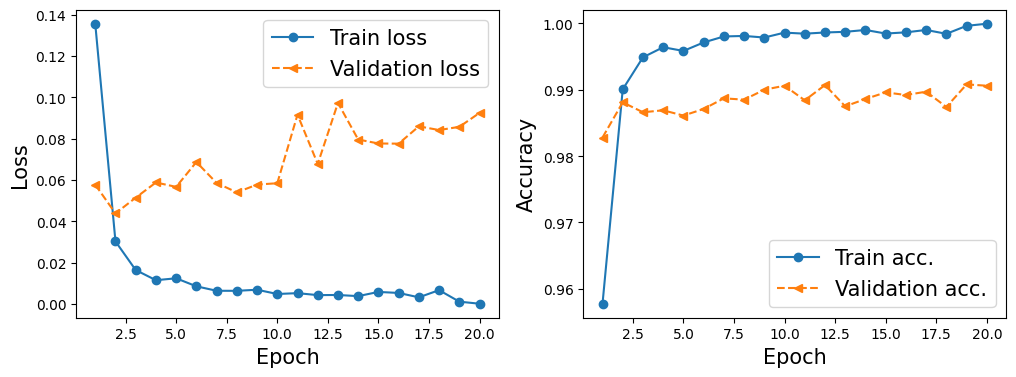

In [37]:
import matplotlib.pyplot as plt
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('images/15_12.png', dpi=300)
plt.show()

In [38]:
test_results = model.evaluate(mnist_test.batch(20))
print('\n테스트 정확도 {:.2f}%'.format(test_results[1]*100))

500/500 [==============================] - 3s 6ms/step - loss: 0.0510 - accuracy: 0.9925

테스트 정확도 99.25%


이 CNN 모델은 99.25% 정확도를 달성했다. 14장에서 DNNClassifier 추정기를 사용했을 때 약 90% 정확도를 얻었다.  

마지막으로 클래스 소속 활률 형태로 예측 결과를 얻은 후 `tf.argmax` 함수로 확률이 최대인 원소를 찾아 예측 레이블로 바꿀 수 있다. 

TensorShape([12, 10])
tf.Tensor([2 0 4 8 7 6 0 6 3 1 8 0], shape=(12,), dtype=int64)


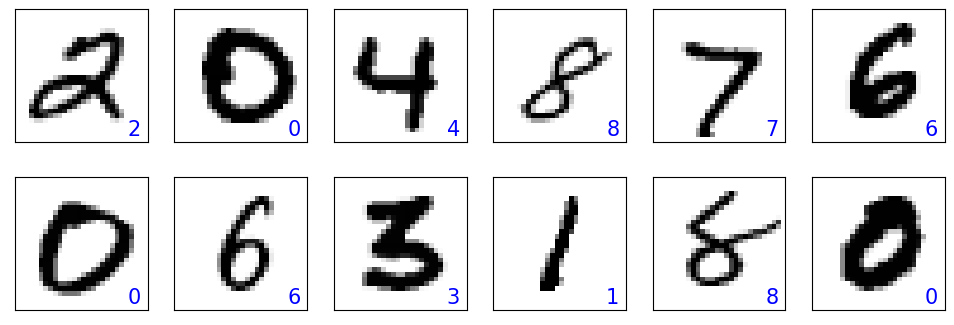

In [39]:
batch_test = next(iter(mnist_test.batch(12)))

preds = model(batch_test[0])

tf.print(preds.shape)
preds = tf.argmax(preds, axis=1)
print(preds)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = batch_test[0][i, :, :, 0]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, '{}'.format(preds[i]), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
#plt.savefig('images/15_13.png', dpi=300)
plt.show()

In [40]:
import os

if not os.path.exists('models'):
    os.mkdir('models')


model.save('models/mnist-cnn.h5')